# LSTM vs. Transformers for Stock Price Prediction

---



> Question: Which model is better for predicting stock prices, using only previous stock price data, LSTM's or Transformers?

We will evaluate our models on several axis: First, prediction performance on the test data set. Second, the variance of our models predictions over the variance of the underlying test data. Third, the speed of training and inference, and lastly but related, the number of parameters in our model.

Evaluation Metrics:

For prediction performance: Mean Absolute Percentage Error (MAPE).
Specific implementation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

For uncertainty: np.var('our predictions') / np.var('actual data')

For speed: seconds of runtime.
Specific implementation: https://docs.python.org/3/library/timeit.html

Implementation steps:

1. Set up our helper classes (`ETL`, `PredictAndForecast`, `Evaluate`). ✅
2. Implement an LSTM as a baseline.✅
3. Implement a transformer architecture for timeseries regression.✅
4. Train our models and use them for inference, measuring performance as we go.✅
5. Evaluate our models' performances against our test set. ✅
6. Visualize our predictions as a sanity check.✅

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import yfinance as yf

In [2]:
FILE_PATH = '../data/amzn-etf.csv'


if os.path.exists(FILE_PATH):
    data = pd.read_csv(FILE_PATH)
else:
    data = yf.Ticker("AMZN")
    data = data.history(period="max")
    data.to_csv(FILE_PATH)

In [3]:
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1,1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
2,1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
3,1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
4,1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0
...,...,...,...,...,...,...,...,...
6690,2023-12-14 00:00:00-05:00,149.929993,150.539993,145.520004,147.419998,58400800,0.0,0.0
6691,2023-12-15 00:00:00-05:00,148.380005,150.570007,147.880005,149.970001,110039100,0.0,0.0
6692,2023-12-18 00:00:00-05:00,150.559998,154.850006,150.050003,154.070007,62512800,0.0,0.0
6693,2023-12-19 00:00:00-05:00,154.399994,155.119995,152.690002,153.789993,43171300,0.0,0.0


In [4]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15 00:00:00-04:00,0.097917
1,1997-05-16 00:00:00-04:00,0.086458
2,1997-05-19 00:00:00-04:00,0.085417
3,1997-05-20 00:00:00-04:00,0.081771
4,1997-05-21 00:00:00-04:00,0.071354
...,...,...
6690,2023-12-14 00:00:00-05:00,147.419998
6691,2023-12-15 00:00:00-05:00,149.970001
6692,2023-12-18 00:00:00-05:00,154.070007
6693,2023-12-19 00:00:00-05:00,153.789993


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

/var/folders/5t/1wwb4x_d4hd53smqcd96d_500000gn/T/ipykernel_83780/1819287010.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])
/var/folders/5t/1wwb4x_d4hd53smqcd96d_500000gn/T/ipykernel_83780/1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


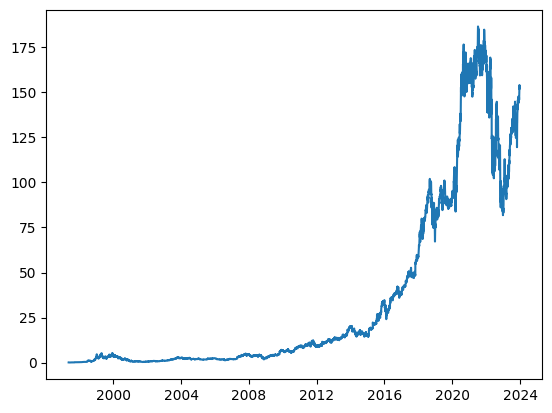

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27 00:00:00-04:00,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28 00:00:00-04:00,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29 00:00:00-04:00,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30 00:00:00-04:00,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02 00:00:00-04:00,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-12-14 00:00:00-05:00,147.419998,148.839996,147.479996,145.889999,147.419998,146.880005,144.520004,146.880005
2023-12-15 00:00:00-05:00,149.970001,147.419998,148.839996,147.479996,145.889999,147.419998,146.880005,144.520004
2023-12-18 00:00:00-05:00,154.070007,149.970001,147.419998,148.839996,147.479996,145.889999,147.419998,146.880005


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670009e-02, 7.50000030e-02, 6.97920024e-02, ...,
        8.54170024e-02, 8.64579976e-02, 9.79169980e-02],
       [7.65630007e-02, 7.91670009e-02, 7.50000030e-02, ...,
        8.17710012e-02, 8.54170024e-02, 8.64579976e-02],
       [7.52599984e-02, 7.65630007e-02, 7.91670009e-02, ...,
        7.13540018e-02, 8.17710012e-02, 8.54170024e-02],
       ...,
       [1.54070007e+02, 1.49970001e+02, 1.47419998e+02, ...,
        1.45889999e+02, 1.47419998e+02, 1.46880005e+02],
       [1.53789993e+02, 1.54070007e+02, 1.49970001e+02, ...,
        1.47479996e+02, 1.45889999e+02, 1.47419998e+02],
       [1.52119995e+02, 1.53789993e+02, 1.54070007e+02, ...,
        1.48839996e+02, 1.47479996e+02, 1.45889999e+02]])

In [9]:
shifted_df_as_np.shape

(6688, 8)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.65146866,  0.60750069,  0.58015711, ...,  0.56374968,
         0.58015711,  0.57436632],
       [ 0.64846583,  0.65146866,  0.60750288, ...,  0.58080051,
         0.56374968,  0.58015711],
       [ 0.63055697,  0.64846583,  0.65147061, ...,  0.59538491,
         0.58080051,  0.56374968]])

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6688, 7), (6688,))

In [12]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.57436632,  0.58015711,  0.56374968, ...,  0.59538491,
         0.58015711,  0.60750069],
       [ 0.58015711,  0.56374968,  0.58080051, ...,  0.58015711,
         0.60750288,  0.65146866],
       [ 0.56374968,  0.58080051,  0.59538491, ...,  0.60750288,
         0.65147061,  0.64846583]])

In [13]:
split_index = int(len(X) * 0.95)

split_index

6353

In [14]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6353, 7), (335, 7), (6353,), (335,))

In [15]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6353, 7, 1), (335, 7, 1), (6353, 1), (335, 1))

In [16]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6353, 7, 1]),
 torch.Size([335, 7, 1]),
 torch.Size([6353, 1]),
 torch.Size([335, 1]))

In [17]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [18]:
train_dataset

In [19]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [24]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.319
Batch 200, Loss: 0.221
Batch 300, Loss: 0.182

Val Loss: 0.508
***************************************************

Epoch: 2
Batch 100, Loss: 0.111
Batch 200, Loss: 0.064
Batch 300, Loss: 0.043

Val Loss: 0.060
***************************************************

Epoch: 3
Batch 100, Loss: 0.033
Batch 200, Loss: 0.024
Batch 300, Loss: 0.020

Val Loss: 0.013
***************************************************

Epoch: 4
Batch 100, Loss: 0.011
Batch 200, Loss: 0.008
Batch 300, Loss: 0.006

Val Loss: 0.009
***************************************************

Epoch: 5
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.005
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.003
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.001

Val Loss: 0.002
*****************

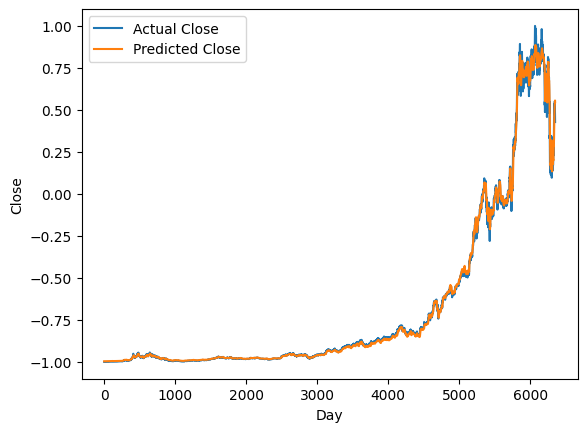

In [25]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [26]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.43596833,   0.43475666,   0.43387848, ..., 144.74177328,
       145.17021564, 144.27252318])

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646240e-02, 7.65634224e-02, 7.52572635e-02, ...,
       1.42300001e+02, 1.38229996e+02, 1.33220001e+02])

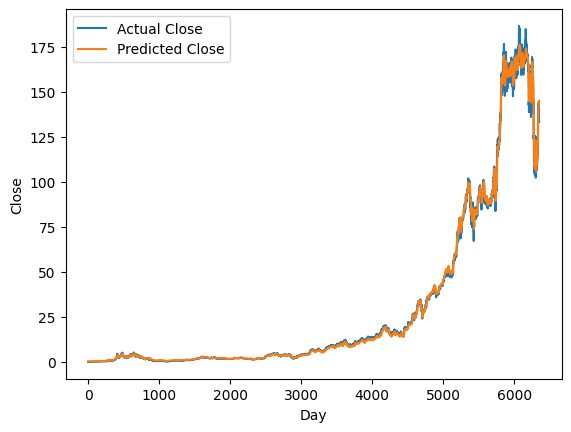

In [28]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [29]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([142.55253977, 140.85242108, 139.22429121, 138.40108316,
       136.39217461, 134.72615779, 133.36584051, 132.05743055,
       131.07119997, 130.00665544, 128.6210765 , 128.74584803,
       128.92634529, 130.02241828, 131.79124648, 131.15479137,
       131.35388611, 130.85234332, 129.47374816, 128.40673304,
       126.52448578, 124.03269584, 122.3621019 , 119.97176994,
       118.45561123, 117.03237878, 116.5906539 , 115.61602451,
       114.83367978, 114.98178292, 116.36278475, 117.29015897,
       118.08935593, 117.39972347, 117.03330699, 116.34914372,
       115.56736453, 114.34659506, 112.08311752, 111.99642609,
       112.59317536, 112.87923806, 113.39956175, 114.78308141,
       116.07492816, 117.70326091, 117.52142136, 116.32889965,
       113.72468138, 111.28843376, 107.47092586, 103.23872918,
        99.09188164,  96.31784048,  94.08505351,  92.54986935,
        90.54311735,  91.68675398,  93.4838897 ,  94.60817294,
        95.78493042,  96.5015698 ,  96.76493868,  96.99

In [30]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([133.61999403, 133.80000218, 137.27999862, 130.74999882,
       129.78999425, 128.72999626, 126.76999641, 127.8200009 ,
       127.51000214, 126.10999987, 129.47999549, 129.82000811,
       133.27000458, 136.44999576, 126.82000007, 128.550002  ,
       126.27999784, 123.52999973, 124.66000228, 122.19000296,
       118.54000021, 117.30999869, 113.7799986 , 115.1500009 ,
       114.41000352, 118.01000261, 114.80000312, 112.9999994 ,
       115.87999784, 121.0899976 , 120.94999682, 120.30000211,
       114.5599978 , 113.66999779, 112.20999975, 112.90000182,
       112.52999896, 106.90000102, 113.79000044, 116.36000013,
       115.07000006, 115.24999988, 119.31999941, 119.81999983,
       120.59999903, 115.66000316, 110.95999871, 103.41000343,
       102.44000258,  96.79000095,  92.12000272,  89.30000318,
        90.98000337,  90.52999879,  89.98000341,  86.13999935,
        96.62999718, 100.79000079,  98.48999771,  98.94000245,
        97.1200027 ,  94.84999854,  94.13999938,  92.45

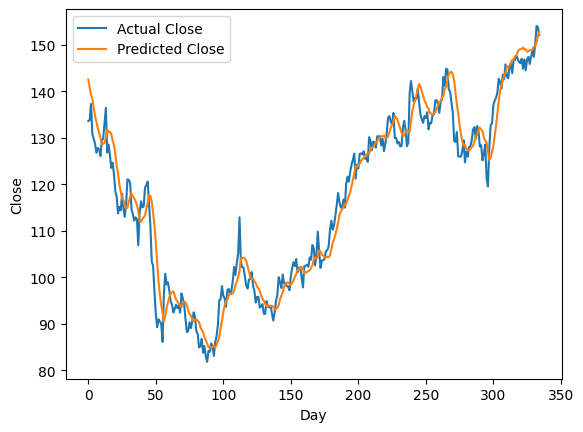

In [31]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [34]:
from sklearn.metrics import mean_absolute_percentage_error

class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

baseline_evals = Evaluate(new_y_test, test_predictions)
baseline_evals.mape, baseline_evals.var_ratio

(0.028042548695971194, 0.022927266770346844)